In [1]:
import torch

In [2]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(16 * 1920 * 1080, 10)

    def forward(self, x):
        return self.fc(self.flatten(self.conv1(x)))

model = CustomModel()
model.eval()

sm = torch.jit.script(model.to(torch.float32))
# sm.save(f"model.pt")


In [3]:
x = torch.randn(1, 3, 1920, 1080).to(torch.float32)
y = model(x)
y.shape

torch.Size([1, 10])

In [4]:
x = torch.randn(1, 3, 1080, 1920).to(torch.float32)
y = model(x)

In [5]:
class Sobel(torch.nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        sobel_dx = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]], dtype=torch.float32)

        sobel_dy = torch.tensor([[-1, -2, -1],
                                [ 0,  0,  0],
                                [ 1,  2,  1]], dtype=torch.float32)

        kernel_dx = sobel_dx.view(1,1,3,3).repeat(3,1,1,1).contiguous()
        kernel_dy = sobel_dy.view(1,1,3,3).repeat(3,1,1,1).contiguous()

        self.kernel_dx = torch.nn.Parameter(kernel_dx, requires_grad=False)
        self.kernel_dy = torch.nn.Parameter(kernel_dy, requires_grad=False)


        # sobel_kernel = torch.stack([sobel_dx, sobel_dy])   # [2,3,3]
        # sobel_kernel = sobel_kernel.unsqueeze(1).repeat(1, 3, 1, 1)  # [2,3,3,3]
        # sobel_kernel = sobel_kernel.to(torch.float32)

        # self.sobel_kernel = torch.nn.Parameter(sobel_kernel, requires_grad=False)
        # # self.sobel_cnn = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False).to(torch.float16)
        # # self.sobel_cnn.weight = torch.nn.Parameter(sobel_kernel, requires_grad=False)

    def forward(self, x):
        # return self.sobel_cnn(x)
        grad_x = torch.nn.functional.conv2d(x, self.kernel_dx, padding=1, groups=3)
        grad_y = torch.nn.functional.conv2d(x, self.kernel_dy, padding=1, groups=3)

        grad_mag = torch.sqrt(grad_x ** 2 + grad_y ** 2)
        return grad_mag

        # return torch.nn.functional.conv2d(x, self.sobel_kernel, padding=1,stride=1)



# sobel = Sobel().to('mps').to(torch.float32)
# sm = torch.jit.script(sobel)
# sm.save("models/sobel_float32.pt")
# sobel = Sobel().to('mps').to(torch.float16)
# sm = torch.jit.script(sobel)
# sm.save("models/sobel_float16.pt")

In [23]:
sobel = Sobel().to(torch.float32)
sobel.eval()
# sm = torch.jit.optimize_for_inference(torch.jit.script(sobel.to(torch.float16).to('mps')))
sm = torch.jit.script(sobel)
sm.save("sobel.pt")

In [7]:
from torchvision.io import decode_image
from PIL import Image
import matplotlib.pyplot as plt
def show_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


img = decode_image('coast.jpeg', mode='RGB')
img = img.to(torch.float32) / 255.0
# plt.imshow(img)
# plt.show()
print(img.shape)
print(img.permute(1, 2, 0).shape)
# show_image(img)

torch.Size([3, 1080, 1920])
torch.Size([1080, 1920, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.203823].


torch.Size([3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])


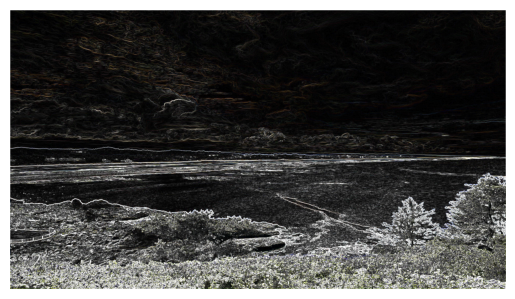

In [8]:
sobel_img = sobel(img.unsqueeze(0))
print(img.shape)
print(sobel_img.shape)
show_image(sobel_img.squeeze(0))

torch.Size([3, 1080, 1920])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.203823].


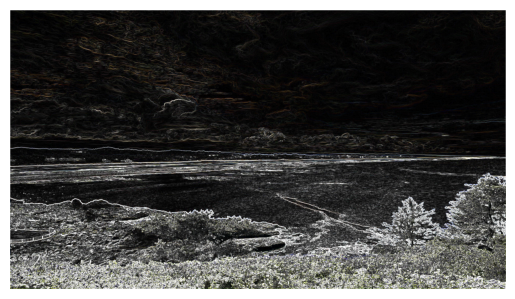

In [9]:
def chat_sobel(img):
    import torch
    import torch.nn.functional as F

    # assume img is a FloatTensor of shape [3, H, W], e.g. normalized to [0,1]
    # step 0: add batch dim
    img = img.unsqueeze(0)   # now [1, 3, H, W]

    # 1. define 2D Sobel kernels
    sobel_dx = torch.tensor([[-1., 0., 1.],
                            [-2., 0., 2.],
                            [-1., 0., 1.]], dtype=torch.float32)
    sobel_dy = torch.tensor([[-1., -2., -1.],
                            [ 0.,  0.,  0.],
                            [ 1.,  2.,  1.]], dtype=torch.float32)

    # 2. reshape them into conv filters of shape (out_ch, in_ch_per_group, kH, kW)
    #    here we want 1 filter per input channel, done 3 times (one group per channel)
    kernel_dx = sobel_dx.view(1,1,3,3).repeat(3,1,1,1)  # → (3,1,3,3)
    kernel_dy = sobel_dy.view(1,1,3,3).repeat(3,1,1,1)  # → (3,1,3,3)

    # 3. apply grouped conv so each channel is convolved separately
    grad_x = F.conv2d(img, kernel_dx, padding=1, groups=3)  # [1,3,H,W]
    grad_y = F.conv2d(img, kernel_dy, padding=1, groups=3)  # [1,3,H,W]

    # 4. compute magnitude per channel
    grad_mag = torch.sqrt(grad_x**2 + grad_y**2)            # [1,3,H,W]

    # 5. squeeze off the batch dim
    out_img = grad_mag.squeeze(0)   # → [3, H, W]

    print(out_img.shape)            # torch.Size([3, 1080, 1920])
    return out_img

img2 = img.clone()
out_img = chat_sobel(img2)
show_image(out_img)

In [19]:
stm = torch.jit.load('../style-transfer/models/exports/mps/candy_float16.pt', map_location='mps')

stm.eval()

# in_img = img.clone().to(torch.float16).to('mps')
# out_img = stm(in_img.unsqueeze(0)).squeeze(0).to(torch.float32).to('cpu')
# print(out_img.shape)            # torch.Size([3, 1080, 1920])
# show_image(out_img.detach())


# frozen_mod = torch.jit.optimize_for_inference(stm)

# in_img = img.clone().to(torch.float16).to('mps')
# out_img = frozen_mod(in_img.unsqueeze(0)).squeeze(0).to(torch.float32).to('cpu')
# print(out_img.shape)            # torch.Size([3, 1080, 1920])
# show_image(out_img.detach())


stm.extra_repr()

'original_name=TransformerNet'

In [11]:
# stm = torch.jit.load('../style-transfer/models/exports/mps/candy_float16.pt', map_location='mps')
# # stm = stm.to(torch.float32)
# # print(stm.device)
# stm.eval()
# stm = stm.to('cpu')

# stm = stm.to(torch.float32)
# in_img = img.clone().to(torch.float32).to('cpu')
# out_img = stm(in_img.unsqueeze(0)).squeeze(0).to(torch.float32).to('cpu')
# print(out_img.shape)            # torch.Size([3, 1080, 1920])
# show_image(out_img.detach())

In [12]:

# stm.save("starry.pt")

# styled_img = stm(img.unsqueeze(0)).squeeze(0)
# print(styled_img.shape)
# show_image(styled_img)
# show_image(stm(img2.unsqueeze(0)).squeeze(0))